In [1]:
import sys
sys.path.insert(0, "trace/")
sys.path.insert(0, "specgen/")
sys.path.insert(0, "specgen/fortranlib/")

import os #checking status of requested files
#os.environ["OMP_NUM_THREADS"] = "24"

import numpy as np #numpy gives us better array management 

#Will be used to create FITS writer 
from astropy.io import fits #astropy modules for FITS IO

import matplotlib  #ploting
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import downscale_local_mean, resize

from tqdm.notebook import trange
from tqdm.notebook import tqdm as tqdm_notebook

import pyfftw
import multiprocessing as mp
#import scipy.signal
import scipy.fft
from matplotlib.colors import LogNorm
ncpu=mp.cpu_count()
pyfftw.config.NUM_THREADS = ncpu

#Trace Library
import tracepol as tp

#Used to monitor progress for multiprocessing pools
def barupdate(result):
    pbar.update()

## How to Compile Fortran libraries
in the utils folder run:  
  
`f2py3 -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lpthread -liomp5 --fcompiler=intelem --f90flags='-parallel -mkl -qopenmp' --f77flags='-parallel -mkl -qopenmp'`  
  
`f2py3 -c binmodels_py.pyf binmodels_py.f90 precision.f90 --fcompiler=intelem`  
  
move the .so files to your library import location (or current directory for your Jupyter notebook)

## Maestria Specific notes:

### Note: On maestria the intel compiler is not supported.  Please use gfortran instead:  
  
`f2py3 -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lgomp --f90flags='-fopenmp' --f77flags='-fopenmp'`
    
`f2py3 -c binmodels_py.pyf binmodels_py.f90 precision.f90`   
  
### skimage-

skimage package is not installed.  Local install needed:  
  
`pip3 install --user scikit-image`  



In [2]:
import spgen as spgen #Python Routines for SpecGen Routines and wrappers for fast-Transit-model.

In [3]:
## Debugging cells

#if not sys.warnoptions:
#    import warnings
#    warnings.simplefilter("ignore")

## For Debuging
#import importlib

#importlib.reload(spgen) 

## Notebook Parameters  
These parameters set up the work environment and readin model parameters

todo:  
- add rprstype to get planetmodel type

In [4]:
workdir='/home/loicalbert/Documents/python/gitdir/jwst-mtl/SOSS/' #root folder for local files
response_file=workdir+'tables/NIRISS_Throughput_STScI.fits'
pmodeltype=2  ## Needs to be added as model parameter.  
trace_file=workdir+'./trace/NIRISS_GR700_trace.csv'
model_dir = '/data/JWST/'
kernel_dir = '/data/JWST/' #'/data/JWST/Kernel/Kernels1/' currently hard coded in /Kernel/Kernels1/ need changing

pars=spgen.ModelPars()              #Set up default parameters
filename=workdir+'simpars.txt'      #location of file for parameter import 
pars=spgen.read_pars(filename,pars) #read in parameter file

pars.noversample=4 #example of changing a model parameter

In [5]:
print(model_dir+pars.pmodelfile[0])

/data/JWST/pmodels/hd209458.csv


## Full Run to get 1-frame  
  
1) Get Instrument Response  
  
todo:  
- responce file should be a parameter

2) Read in Stellar Atmosphere  
  
todo: 
- ~~read in limb-darkening coefficients~~
- read in new Pheonix stellar models 

3) Read in Planet atmosphere 
  
todo:  
- add pmodeltype as model parameter  

4) Set up Trace 
  
todo:  
- set up as a default model parameter

5) Resample Spectra onto a common grid  

todo:  
- ~~common wavelength grid~~
- ~~bin starflux~~
- ~~bin planet r/R*~~
- ~~bin limb-darkening~~
- add interpolation when resolution is insufficient  
  
6) Transit Model  
  
todo:  
- ~~create solin array from pars.sol for each wavelength.~~
- ~~calculate transit-depth at each wavelength~~
- requires integration time
- time should be an array.
- add multiplanet capabilities  
  
7) Reading Kernels
  
todo:  
- resampling of Kernels is not ideal.  Needs thought.
  
8) Generate image with n=1,2,3 orders  
  
todo:
- ~~use resampled star,planet models~~
- ~~use transit model~~  
- scale total flux on detector using ETC output
- add orders -2,-1,0

In [6]:
print('Reading in Planet model')
planetmodel_wv,planetmodel_rprs=spgen.readplanetmodel(model_dir+pars.pmodelfile[0],pmodeltype)

Reading in Planet model


In [7]:
# In the following bloc, the planet spectrum gj1214.txt can not be read. Have to handle that. Only hd209 works.

In [8]:
#1 Instrument response

print('Reading in Response')
response=spgen.readresponse(response_file)

#2 Stellar Atmosphere Model

print('Reading Stellar model')
starmodel_wv,starmodel_flux,ld_coeff=spgen.readstarmodel(model_dir+pars.modelfile,pars.nmodeltype)

#3 Read in Planet atmosphere  

print('Reading in Planet model')
planetmodel_wv,planetmodel_rprs=spgen.readplanetmodel(model_dir+pars.pmodelfile[0],pmodeltype)

#4 Set up Trace 

print('Setting up Trace')
tracePars = tp.get_tracepars(trace_file)

Reading in Response
Reading Stellar model
Reading in Planet model
Setting up Trace


trace/tracepol.py:88: RankWarning: Polyfit may be poorly conditioned
  pars = trace_polynomial(trace, m=m)


In [9]:
# in the following bloc, the kernel_dir is hard coded, need to be coded out.
# in fact, one should have to run (upstream) the WebbPSF code that will generate these kernels rather than rely on 
# a library of fits files.

In [10]:
#5 Resample star and planet models to common uniform in wavelength grid.

print('Resampling star and planet model')
#Get wavelength spacing to use for resampling
dw,dwflag=spgen.get_dw(starmodel_wv,planetmodel_wv,pars,tracePars)

#dw = dw/100

print("Wavelength spacing (A): ", dw,dwflag)
#Resample onto common grid.
bin_starmodel_wv,bin_starmodel_flux,bin_ld_coeff,bin_planetmodel_wv,bin_planetmodel_rprs=\
        spgen.resample_models(dw,starmodel_wv,starmodel_flux,ld_coeff,\
        planetmodel_wv,planetmodel_rprs,pars,tracePars)

# Make sure the array is sorted in increasing wavelengths
ind = np.argsort(bin_starmodel_wv)
bin_starmodel_wv = bin_starmodel_wv[ind]
bin_starmodel_flux = bin_starmodel_flux[ind]
bin_planetmodel_rprs = bin_planetmodel_rprs[ind]

#6 Transit model

print('Setting up Transit Model Parameters')
#This will become a routine
#Setup static Solution parameters (LD,r/R* and TED are wavelength dependent)
#This is a single planet example
solin=np.zeros(8+10*pars.nplanet) #TF5 style transit solution array
time=0.0    #time
itime=0.0001 #integration time (days)
solin[0]=np.copy(pars.sol[0]) #Mean stellar density
solin[8]=np.copy(pars.sol[1]) #EPO
solin[9]=np.copy(pars.sol[2]) #Period
solin[10]=np.copy(pars.sol[3]) #Impact parameter
solin[12]=np.copy(pars.sol[4]) #ECW
solin[13]=np.copy(pars.sol[5]) #ESW
solin[14]=np.copy(pars.sol[6]) #KRV
solin[16]=np.copy(pars.sol[7]) #ELL
solin[17]=np.copy(pars.sol[8]) #ALB 

#7 #Read in Kernels

print('Reading in and resampling PSF Kernel')
kernels,kernels_wv=spgen.readkernels(kernel_dir)
#resize Kernels 
#limit oversampling to be: 1<10
kernel_resize=[]
for k in kernels:
    kernel_resize.append(resize(k,(128*pars.noversample,128*pars.noversample)))

Resampling star and planet model
Wavelength spacing (A):  0.9599941999986186 0
Setting up Transit Model Parameters
Reading in and resampling PSF Kernel


# Flux Normalization Piece of Code

-39.001284214958424
Synthetic magnitude of input spectrum: -39.00
Synthetic magnitude of normalized spectrum:   8.00


trace/tracepol.py:88: RankWarning: Polyfit may be poorly conditioned
  pars = trace_polynomial(trace, m=m)


Best calculations for the estimated electron counts for the whole order 1 trace:
elec_per_sec 85970947.88780257
Best calculations for the estimated electron counts for the whole order 2 trace:
elec_per_sec 24790248.842066813
expected_flux_calibration returns adu/sec using a detector gain of 1.6 e-/adu.
[53731842.4298766  15493905.52629176]


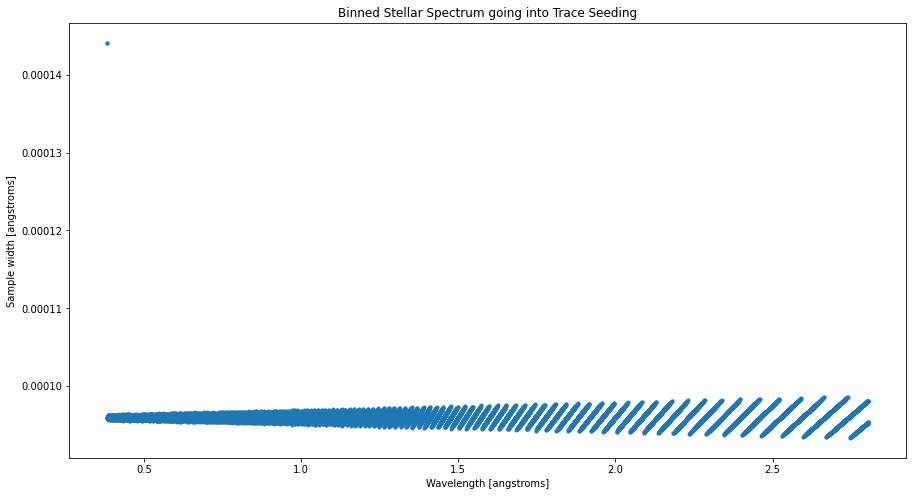

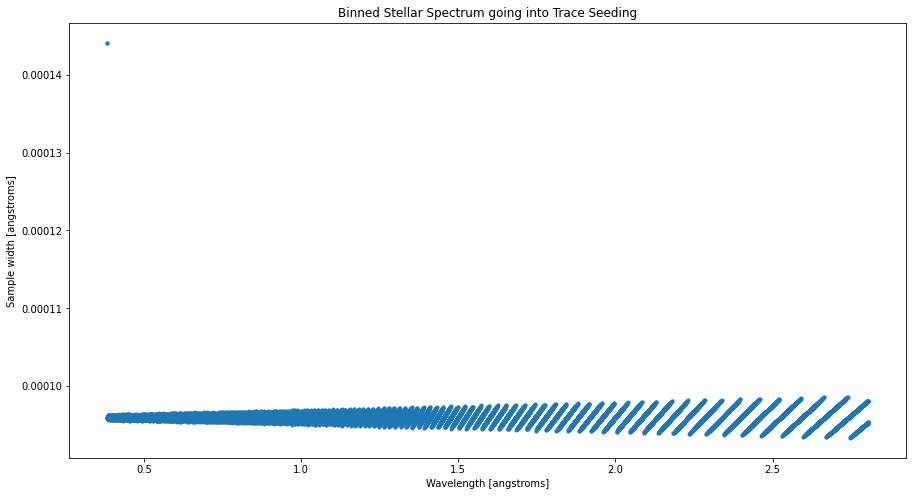

In [11]:
import synthesizeMagnitude as smag
expected_counts = smag.expected_flux_calibration('K',8.0,bin_starmodel_wv/10000,
                                                 bin_starmodel_flux,[1,2],
                                                 convert_to_adupersec=True,
                                                 verbose=True)
print(expected_counts)

## 8 - a) Create the convolved Image - for a flat spectrum - to devise the flux normalizing scale.

In [12]:
if False:
    xmax=pars.xout*pars.noversample
    ymax=pars.yout*pars.noversample
    convolved_image=np.zeros((ymax,xmax))

    # Initialize a flat spectrum with same binning as the model spectrum
    bin_flatspectrum_wv = np.copy(bin_starmodel_wv)
    bin_flatspectrum_flux = np.copy(bin_starmodel_flux) * 0 + 1.0
    # Initialize the planet radius to be zero
    bin_noplanet_rprs = np.copy(bin_planetmodel_rprs)*0.0
    # Test with a throughput and quantum yield set to 1
    flatresponse = response.copy()
    flatresponse.response[1] = response.response[1] * 0.0 + 1.0
    flatresponse.quantum_yield = response.quantum_yield * 0.0 + 1.0

    # Here enter the list of orders to simulate
    order_list = np.array([1])
    for norder in order_list: 

        print('norder',norder)

        pixels=spgen.gen_unconv_image(pars,flatresponse,bin_flatspectrum_wv,bin_flatspectrum_flux,\
                    bin_ld_coeff,bin_noplanet_rprs,time,itime,solin,norder,tracePars)

        pixels_t=np.copy(pixels.T)
        #Enable threads (not working?!?!)
        #pyfftw.config.NUM_THREADS = 1 #do not need multi-cpu for pools
        #with scipy.fft.set_backend(pyfftw.interfaces.scipy_fft):
        # Turn on the cache for optimum performance
        #pyfftw.interfaces.cache.enable()

        #do the convolution
        x=pixels_t*0+1.0e-10

        nwv=len(kernels_wv) #number of wavelengths to process
        pbar = tqdm_notebook(total=nwv)  #Will make a progressbar to monitor processing.  
        pool = mp.Pool(processes=ncpu)  #Use lots of threads - because we can! 

        results = [pool.apply_async(spgen.convolve_1wv,\
                                args=(pixels_t,kernel_resize,kernels_wv,wv_idx,pars,norder,tracePars,),\
                                callback=barupdate) for wv_idx in range(nwv)]

        pixels_c = [p.get() for p in results]

        pool.close()
        pool.join()

        #bring together the results
        x=pixels_t*0+1.0e-10
        for p in pixels_c:
            x+=p

        pixels_c=None #release Memory

        convolved_image+=x

# Just plot the 2D images and summed flux to see if all is good

In [13]:
if False:
    plt.figure(figsize=(15,5))
    plt.imshow(convolved_image)
    #plt.close()
    plt.figure(figsize=(5,15))
    plt.imshow(pixels)
    #plt.close()

    from astropy.io import fits
    hdu = fits.PrimaryHDU()
    hdu.data = pixels
    hdu.writeto('test.fits',overwrite=True)

    toto = pixels*1
    toto = downscale_local_mean(toto,(pars.noversample,pars.noversample))
    plt.figure(figsize=(5,15))
    plt.imshow(toto)
    #plt.close()

    # Determine whether the trace is indeed constant.
    # Sum along the columns
    flux = np.sum(toto, axis = 1)
    plt.figure(figsize=(15,5))
    plt.plot(flux)
    plt.xlim((1000,1200))
    plt.ylim((6.3,6.5))

    hdu = fits.PrimaryHDU()
    toto = downscale_local_mean(convolved_image,(pars.noversample,pars.noversample))
    hdu.data = np.flip(toto,axis=0)
    hdu.writeto('trace_order2.fits',overwrite=True)

    sumpixel = np.sum(pixels)
    sumtrace = np.sum(convolved_image)
    print('Sum seed trace = {:}; Sum convolved trace = {:}; Ratio = {:}'.format(sumpixel,sumtrace,sumtrace/sumpixel))

## 8-b) Create Convolved Image

In [14]:
order_list = np.array([1,2])
nslice = np.size(order_list)

xmax=pars.xout*pars.noversample
ymax=pars.yout*pars.noversample
convolved_image=np.zeros((nslice,ymax,xmax))


#for norder in range(1,4): #Order to use. (will loop..)
for no in range(np.size(order_list)): 

    norder = order_list[no]
    print('Generating Order {:}'.format(norder))

    pixels=spgen.gen_unconv_image(pars,response,bin_starmodel_wv,bin_starmodel_flux,\
                bin_ld_coeff,bin_planetmodel_rprs,time,itime,solin,norder,tracePars)

    pixels_t=np.copy(pixels.T)

    #Enable threads (not working?!?!)
    #pyfftw.config.NUM_THREADS = 1 #do not need multi-cpu for pools
    #with scipy.fft.set_backend(pyfftw.interfaces.scipy_fft):
    # Turn on the cache for optimum performance
    #pyfftw.interfaces.cache.enable()

    #do the convolution
    x=pixels_t*0+1.0e-10

    nwv=len(kernels_wv) #number of wavelengths to process
    pbar = tqdm_notebook(total=nwv)  #Will make a progressbar to monitor processing.  
    pool = mp.Pool(processes=ncpu)  #Use lots of threads - because we can! 

    results = [pool.apply_async(spgen.convolve_1wv,\
                            args=(pixels_t,kernel_resize,kernels_wv,wv_idx,pars,norder,tracePars,),\
                            callback=barupdate) for wv_idx in range(nwv)]

    pixels_c = [p.get() for p in results]

    pool.close()
    pool.join()

    #bring together the results
    x=pixels_t*0+1.0e-10
    for p in pixels_c:
        x+=p

    pixels_c=None #release Memory

    convolved_image[no,:,:] += x
    
    # Sum in the flux for that order
    actual_counts = np.sum(convolved_image[no,:,:])
    print('Actual counts measured on the simulation = {:} e-/sec'.format(actual_counts))
    print('Ratio of expected/actual counts = {:}'.format(expected_counts[no] / actual_counts))
    convolved_image[no,:,:] = convolved_image[no,:,:] * expected_counts[no] / actual_counts
    

Generating Order 1


3378651380.040302
0.015903340234302503
Generating Order 2


1687794106.2972686
0.00917997371153448


# Now, check whether we recover the expected flux

-39.001284214958424
Synthetic magnitude of input spectrum: -39.00
Synthetic magnitude of normalized spectrum:   8.70
Best calculations for the estimated electron counts for the whole order 1 trace:
elec_per_sec 45118194.816263475


trace/tracepol.py:88: RankWarning: Polyfit may be poorly conditioned
  pars = trace_polynomial(trace, m=m)


Best calculations for the estimated electron counts for the whole order 2 trace:
elec_per_sec 13010107.533765022
expected_flux_calibration returns adu/sec using a detector gain of 1.6 e-/adu.
Order 1: simulated counts = 53731842.4298766 e-/sec, expected counts = 28198871.76016467 e-/sec
Order 2: simulated counts = 15493905.52629178 e-/sec, expected counts = 8131317.208603138 e-/sec
Counts on final image = 36330188.9687678 e-/sec, Expected counts = 36330188.96876781 e-/sec


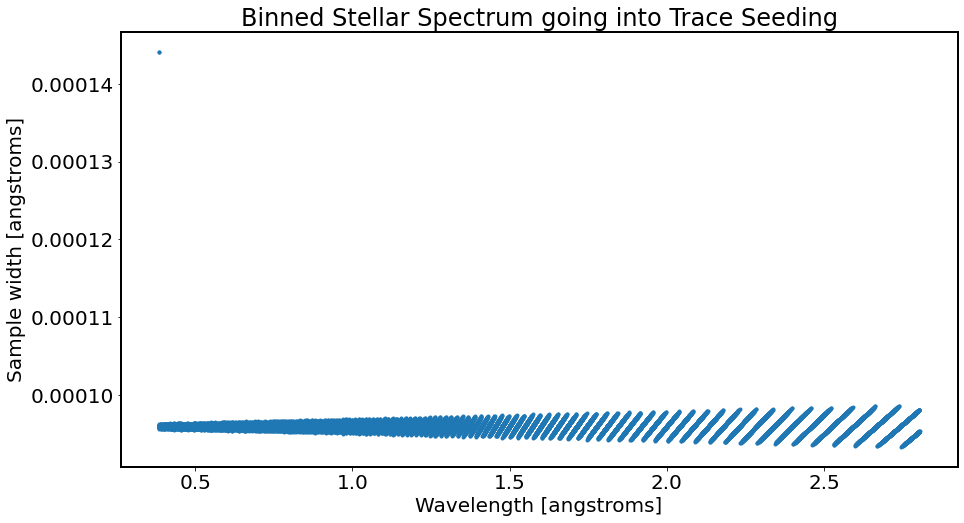

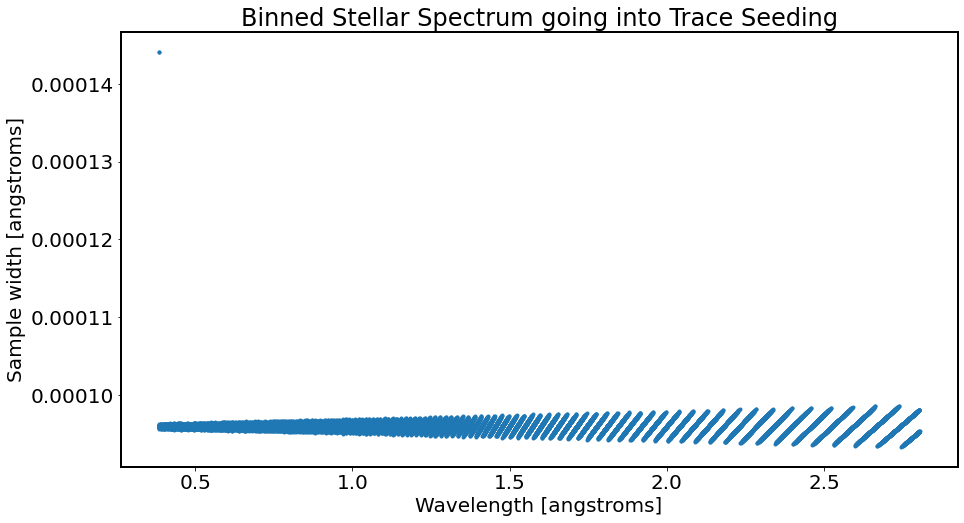

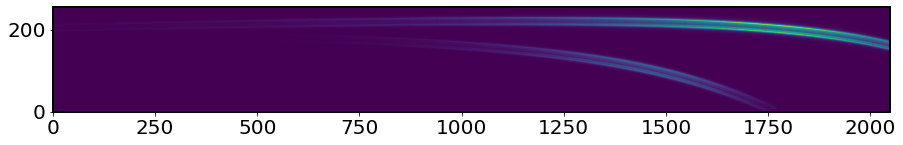

In [37]:
# At this point, the simulation consists in separate images for each order 
# (stored in the 3rd dimension) and has oversampled dimensions.
#
# To produce a simulation in adu/sec rather than e-/sec
convert_to_adupersec = True
expected_counts = smag.expected_flux_calibration('K',8.7,bin_starmodel_wv/10000,
                                                 bin_starmodel_flux,[1,2],
                                                 convert_to_adupersec=convert_to_adupersec,
                                                 verbose=True)

# Initialize a cube that will be flux calibrated 
normalized_cube = np.copy(convolved_image)
for i in range(np.size(order_list)):
    simulated_counts = np.sum(convolved_image[i,:,:])
    print('Order {:}: simulated counts = {:} e-/sec, expected counts = {:} e-/sec'.format(
        order_list[i],simulated_counts,expected_counts[i]))
    normalized_cube[i,:,:] = convolved_image[i,:,:] * expected_counts[i] / simulated_counts
# To bin down to the native pixel size and merge down the cube into a single image, use this function
image_nativesize = downscale_local_mean(np.sum(normalized_cube,axis=0),(pars.noversample,pars.noversample))*pars.noversample**2
# Check that counts are ok
native_counts = np.sum(image_nativesize)
print('Counts on final image = {:} e-/sec, Expected counts = {:} e-/sec'.format(native_counts,np.sum(expected_counts)))
plt.figure(figsize=(15,8))
plt.imshow(image_nativesize, origin='lower')

Brightest pixel on a CDS is 49100 adu or e-


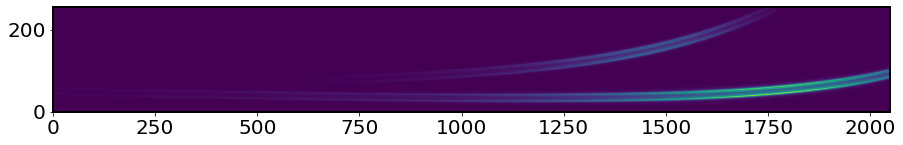

In [38]:
# Here, image is still not in the DMS format. We need to make a flip vertically.
image_nativesize_DMS = np.flip(image_nativesize,axis=0)
plt.figure(figsize=(15,8))
plt.imshow(image_nativesize_DMS, origin='lower')

# Check what is the brightest pixel. Does it make sense?
CDS_integrationtime = 3*5.5 # seconds
maxvalue = np.max(image_nativesize_DMS)*CDS_integrationtime
print('Brightest pixel on a CDS is {:.0F} adu or e-'.format(maxvalue))

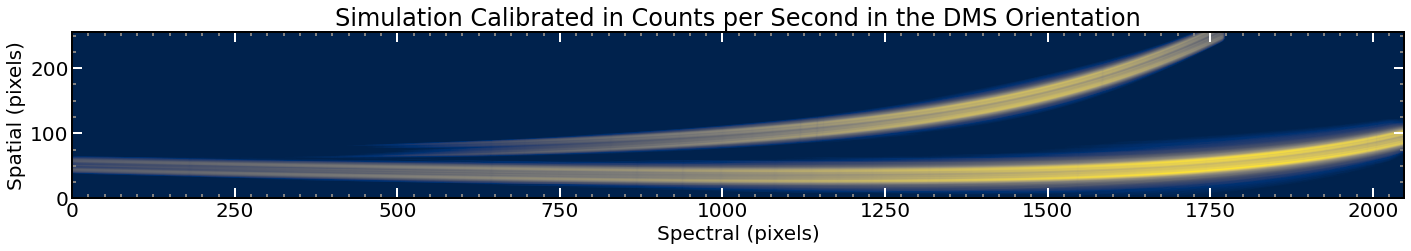

In [39]:
#Plot noise-less image

matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(20,4)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10, width=2,color='white')
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4, width=2,color='grey')


cmap = plt.get_cmap('cividis')
ax.imshow(image_nativesize_DMS,interpolation=None,cmap=cmap,norm=LogNorm(),origin='lower',vmin=5)
ax.axis((0,image_nativesize_DMS.shape[1],0,image_nativesize_DMS.shape[0]))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(25))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(25))

ax.set_title('Simulation Calibrated in Counts per Second in the DMS Orientation')
ax.set_xlabel('Spectral (pixels)')
ax.set_ylabel('Spatial (pixels)')

#plt.show()
fig.tight_layout()
fig.savefig('SOSS_sim.pdf')

In [ ]:
spgen.p2w(tracePars,250,1,0)

## Lots of Plots

In [ ]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(response.wv/10000,response.response[0],lw=2,label='Response')

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Response')

ax.legend()

plt.show()

In [ ]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(starmodel_wv/10000,starmodel_flux,label='Star Model')

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Flux')

ax.legend()

plt.show()

In [ ]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(planetmodel_wv/10000,planetmodel_rprs,label='Planet Model')

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Rp/R$_{\star}$')

ax.legend()

plt.show()

In [ ]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(bin_starmodel_wv/10000,bin_starmodel_flux,label='Resampled Star Model')

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Flux')

ax.legend()

plt.show()

In [ ]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=10, width=2)

ax.plot(bin_planetmodel_wv[bin_planetmodel_rprs>0]/10000,bin_planetmodel_rprs[bin_planetmodel_rprs>0],\
       label='Resampled Planet Model')

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('Rp/R$_{\star}$')

ax.legend()

plt.show()

In [ ]:
##Single Thread example
##Set up FFTW
#pixels_t=np.copy(pixels.T)
#a = pyfftw.empty_aligned((pixels_t.shape[0], pixels_t.shape[1]), dtype='float64')
#b = pyfftw.empty_aligned((kernel_resize[0].shape[0], kernel_resize[0].shape[1]), dtype='float64')
#
##Enable threads (not working?!?!)
#pyfftw.config.NUM_THREADS = ncpu
#
#with scipy.fft.set_backend(pyfftw.interfaces.scipy_fft):
#    # Turn on the cache for optimum performance
#    pyfftw.interfaces.cache.enable()
#
#    #do the convolution
#    x=cpixels*0+1.0e-10
#    a[:,:] = pixels_t
#    #wv_idx=0 #wavelength choice #Wavelength
#    for wv_idx in trange(len(kernels_wv)):
#        
#        b[:,:] = kernel_resize[wv_idx]
#        x1=scipy.signal.fftconvolve(a, b, mode='same')
#        wl=kernels_wv[wv_idx]
#        dwl=0.05
#        for i in range(x1.shape[1]):
#            wlp=spgen.p2w(i,pars.noversample,norder)/10000.0
#            fac=max(0.0,1.0-np.abs(wlp-wl)/dwl)
#            x1[:,i]=x1[:,i]*fac
#        
#        #x1=convolve_1wv(pixels_t,kernel_resize,kernels_wv,wv_idx,pars,norder)
#        
#        x+=x1